Import libraries

In [1]:
import os
import json
import gzip
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import string
import random
import requests
import nltk
from PIL import Image
from io import BytesIO
from collections import defaultdict, Counter
from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
sns.set(font_scale=1.25)
#nltk.download('averaged_perceptron_tagger')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns',50)

Load data. Data was downloaded from https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home for children's books only.

In [2]:
df_books = pd.read_json(os.path.join('data', 'goodreads_books_children.json.gz'), lines = True)
df_books.head()

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,similar_books,description,format,link,authors,publisher,num_pages,publication_day,isbn13,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
0,1599150603,7,[],US,,"[{'count': '56', 'name': 'to-read'}, {'count':...",,false,4.13,B00DU10PUG,[],"Relates in vigorous prose the tale of Aeneas, ...",Paperback,https://www.goodreads.com/book/show/287141.The...,"[{'author_id': '3041852', 'role': ''}]",Yesterday's Classics,162,13,9781599150604,9,,2006,https://www.goodreads.com/book/show/287141.The...,https://s.gr-assets.com/assets/nophoto/book/11...,287141,46,278578,The Aeneid for Boys and Girls,The Aeneid for Boys and Girls
1,1934876569,6,[151854],US,,"[{'count': '515', 'name': 'to-read'}, {'count'...",,false,4.22,,"[948696, 439885, 274955, 12978730, 372986, 216...","To Kara's astonishment, she discovers that a p...",Paperback,https://www.goodreads.com/book/show/6066812-al...,"[{'author_id': '19158', 'role': ''}]",Seven Seas,216,3,9781934876565,3,,2009,https://www.goodreads.com/book/show/6066812-al...,https://images.gr-assets.com/books/1316637798m...,6066812,98,701117,All's Fairy in Love and War (Avalon: Web of Ma...,All's Fairy in Love and War (Avalon: Web of Ma...
2,0590417010,193,[],US,eng,"[{'count': '450', 'name': 'to-read'}, {'count'...",,false,4.43,B017RORXNI,"[834493, 452189, 140185, 1897316, 2189812, 424...",In Newbery Medalist Cynthia Rylant's classic b...,Hardcover,https://www.goodreads.com/book/show/89378.Dog_...,"[{'author_id': '5411', 'role': ''}]",Blue Sky Press,40,1,9780590417013,9,,1995,https://www.goodreads.com/book/show/89378.Dog_...,https://images.gr-assets.com/books/1360057676m...,89378,1331,86259,Dog Heaven,Dog Heaven
3,0915190575,4,[],US,,"[{'count': '8', 'name': 'to-read'}, {'count': ...",,false,4.29,,[],,,https://www.goodreads.com/book/show/3209312-mo...,"[{'author_id': '589328', 'role': ''}, {'author...",,,,9780915190577,,,,https://www.goodreads.com/book/show/3209312-mo...,https://s.gr-assets.com/assets/nophoto/book/11...,3209312,11,3242879,"Moths and Mothers, Feathers and Fathers: A Sto...","Moths and Mothers, Feathers and Fathers: A Sto..."
4,1416904999,4,[],US,,"[{'count': '8', 'name': 'to-read'}, {'count': ...",,false,3.57,,[],WHAT DO YOU DO?\nA hen lays eggs...\nA cow giv...,Board Book,https://www.goodreads.com/book/show/1698376.Wh...,"[{'author_id': '169159', 'role': ''}]",Little Simon,24,1,9781416904991,6,,2005,https://www.goodreads.com/book/show/1698376.Wh...,https://s.gr-assets.com/assets/nophoto/book/11...,1698376,23,1695373,What Do You Do?,What Do You Do?


Only children's books in english are chosen

In [3]:
df_books.replace("",np.nan, inplace = True)
df_books.language_code.value_counts()[:5]

eng      30253
en-US     6197
en-GB     2071
spa       1501
ind       1147
Name: language_code, dtype: int64

In [4]:
eng_books = df_books[(df_books.language_code == 'eng') | (df_books.language_code == 'en-US') | (df_books.language_code == 'en-GB')]
eng_books = eng_books[eng_books.title.apply(lambda x: 1 if x.lower() == x.upper() else 0) == 0].reset_index(drop = True)
eng_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38516 entries, 0 to 38515
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   isbn                  30836 non-null  object 
 1   text_reviews_count    38516 non-null  int64  
 2   series                38516 non-null  object 
 3   country_code          38516 non-null  object 
 4   language_code         38516 non-null  object 
 5   popular_shelves       38516 non-null  object 
 6   asin                  2905 non-null   object 
 7   is_ebook              38516 non-null  object 
 8   average_rating        38516 non-null  float64
 9   kindle_asin           15692 non-null  object 
 10  similar_books         38516 non-null  object 
 11  description           34497 non-null  object 
 12  format                32547 non-null  object 
 13  link                  38516 non-null  object 
 14  authors               38516 non-null  object 
 15  publisher          

Drop columns that are not going to used. Splitting the books as boardbooks and others. Audiobooks are removed from the data. The missing values for number of pages is filled by the median. 

In [5]:
eng_books[eng_books.title != eng_books.title_without_series]

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,similar_books,description,format,link,authors,publisher,num_pages,publication_day,isbn13,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series


In [6]:
eng_books_limit_info = eng_books.drop(columns = ['text_reviews_count','country_code','title_without_series','url', 'asin', 'kindle_asin','isbn', 'isbn13','link', 'publication_day','language_code', 'work_id', 'is_ebook','publication_month','edition_information'])

In [7]:
eng_books_limit_info['format'] = eng_books_limit_info.format.str.lower()
eng_books_limit_info.format.fillna('other', inplace = True)
eng_books_limit_info['is_boardbook'] = eng_books_limit_info.format.apply(lambda x: 1 if 'board' in x else 0)
eng_books_limit_info['is_audiobook'] = eng_books_limit_info.format.apply(lambda x: 1 if (('audio' in x)|('cd' in x)|('mp3' in x)) else 0)

In [8]:
eng_books_limit_info['num_pages'].fillna(0, inplace = True)
eng_books_limit_info['num_pages'] = eng_books_limit_info.num_pages.astype(int, errors = 'ignore')

In [9]:
boardbooks = eng_books_limit_info[((eng_books_limit_info.is_boardbook == 1)&(eng_books_limit_info.ratings_count > 10))]
boardbooks = boardbooks.dropna(subset = ['description']).reset_index(drop = True)
boardbooks['publisher'].fillna("unknown", inplace = True)
median_num_pages = round(boardbooks['num_pages'].median())
boardbooks['num_pages'] = boardbooks['num_pages'].apply(lambda x: median_num_pages if x == 0 else x)

In [10]:
otherbooks = eng_books_limit_info[(eng_books_limit_info.is_boardbook == 0)&(eng_books_limit_info.is_audiobook == 0)&(eng_books_limit_info.ratings_count >= 300)&(eng_books_limit_info.num_pages > 0)]
otherbooks.describe()

,average_rating,num_pages,book_id,ratings_count,is_boardbook,is_audiobook
count,6280.000000,6280.000000,6.280000e+03,6.280000e+03,6280.0,6280.0
mean,4.013119,136.764650,6.030781e+06,7.097841e+03,0.0,0.0
std,0.227675,137.162891,8.344740e+06,4.608330e+04,0.0,0.0
min,1.980000,3.000000,5.000000e+00,3.000000e+02,0.0,0.0
25%,3.870000,40.000000,3.110222e+05,4.760000e+02,0.0,0.0
50%,4.030000,112.000000,9.954300e+05,9.365000e+02,0.0,0.0
75%,4.170000,195.000000,1.028433e+07,2.706000e+03,0.0,0.0
max,4.750000,3520.000000,3.482863e+07,1.876252e+06,0.0,0.0


In [11]:
otherbooks = otherbooks.dropna(subset = ['description']).reset_index(drop = True)
otherbooks['publisher'].fillna("unknown", inplace = True)
otherbooks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6042 entries, 0 to 6041
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   series            6042 non-null   object 
 1   popular_shelves   6042 non-null   object 
 2   average_rating    6042 non-null   float64
 3   similar_books     6042 non-null   object 
 4   description       6042 non-null   object 
 5   format            6042 non-null   object 
 6   authors           6042 non-null   object 
 7   publisher         6042 non-null   object 
 8   num_pages         6042 non-null   int32  
 9   publication_year  5817 non-null   object 
 10  image_url         6042 non-null   object 
 11  book_id           6042 non-null   int64  
 12  ratings_count     6042 non-null   int64  
 13  title             6042 non-null   object 
 14  is_boardbook      6042 non-null   int64  
 15  is_audiobook      6042 non-null   int64  
dtypes: float64(1), int32(1), int64(4), object(

In [12]:
books = pd.concat([otherbooks, boardbooks])
books = books.sort_values(by = ['title', 'ratings_count'], ascending = False).drop_duplicates(subset = ['title'], keep = 'first').reset_index(drop = True)

In [13]:
author = defaultdict(list)
for index, data in enumerate(books['authors']):
    for i in range(len(data)):
        author[index].append(data[i]['author_id'])
a = dict(author)
df_authors = pd.DataFrame(list(a.items()), columns = ['remove','authors_id']).drop(columns = 'remove')
df_authors['authors_id'] = df_authors.authors_id.apply(lambda x: ' '.join(x))

In [14]:
books = books.join(df_authors)

The description text of the books are tokenized to get the number of words in the description. Books with description word count greater than 500 are removed.

In [15]:
books['desc_sentnce_count'] = books.description.apply(lambda x: len(sent_tokenize(x)))
books['desc_words'] = books.description.apply(lambda x: word_tokenize(x)).apply(lambda lst: [w for w in lst if w[0] not in string.punctuation])
books['desc_word_count'] = books.desc_words.apply(lambda x: len(x))
books = books[books.desc_word_count < 500]

More than 95% of the books have a desscription with less than 200 words. 

Text(0.5, 1.0, 'Distribution of word counts')

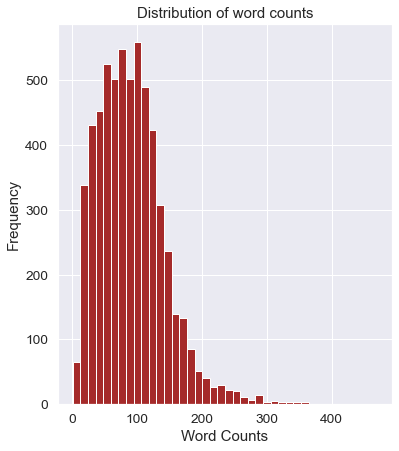

In [44]:
books.desc_word_count.hist(bins = 40, figsize = (6,7), color = 'brown')
plt.xlabel("Word Counts")
plt.ylabel('Frequency')
plt.title("Distribution of word counts")

Text(0.5, 1.0, 'Spread of description word count')

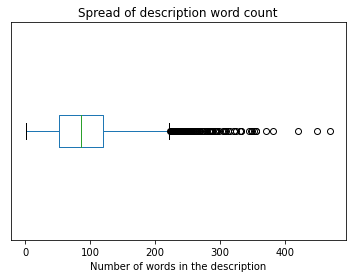

In [17]:
books['desc_word_count'].plot(kind='box', vert=False)
plt.xlabel('Number of words in the description')
plt.yticks(ticks = [0], labels = [" "])
plt.title("Spread of description word count")

<AxesSubplot:title={'center':'Number of books by published year'}, xlabel='publication_year'>

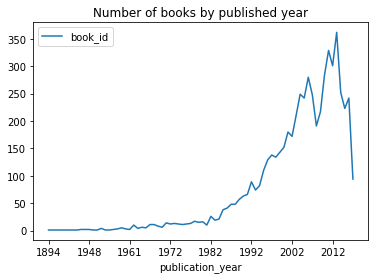

In [18]:
books[~((books.publication_year.isna())|(books.publication_year > '2017'))].groupby('publication_year').agg({'book_id': 'size'}).plot(title="Number of books by published year")

Most books in the dataset were published between 1995 and 2017. The books from the earlier period includes timeless, classic collections that are still being read. 

In [19]:
#can try to use series and shelves names
books = books.drop(columns = ['series','popular_shelves','similar_books','publication_year','format','authors','is_audiobook'])
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5985 entries, 0 to 5986
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   average_rating      5985 non-null   float64
 1   description         5985 non-null   object 
 2   publisher           5985 non-null   object 
 3   num_pages           5985 non-null   int64  
 4   image_url           5985 non-null   object 
 5   book_id             5985 non-null   int64  
 6   ratings_count       5985 non-null   int64  
 7   title               5985 non-null   object 
 8   is_boardbook        5985 non-null   int64  
 9   authors_id          5985 non-null   object 
 10  desc_sentnce_count  5985 non-null   int64  
 11  desc_words          5985 non-null   object 
 12  desc_word_count     5985 non-null   int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 654.6+ KB


Around 7% of the total books are boardbooks, which are mostly preferred for babies and toddlers.

Text(0.5, 1.02, 'Number of boardbooks and other books')

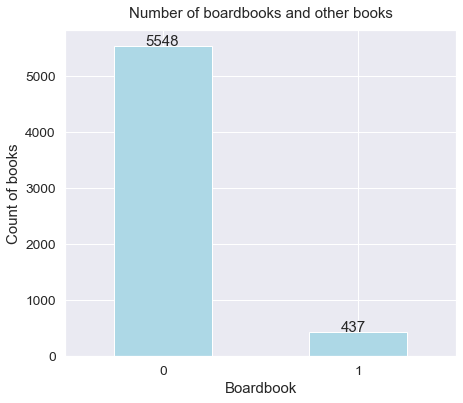

In [20]:
ax = books['is_boardbook'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0, color = 'lightblue')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + .16, p.get_height() + 10))
    
plt.xlabel("Boardbook")
plt.ylabel("Count of books")
plt.title("Number of boardbooks and other books", y=1.02)

Frequent words in the book titles

[Text(0.5, 0, 'Frequency'),
 Text(0.5, 1.0, 'Most frequent words in the book title')]

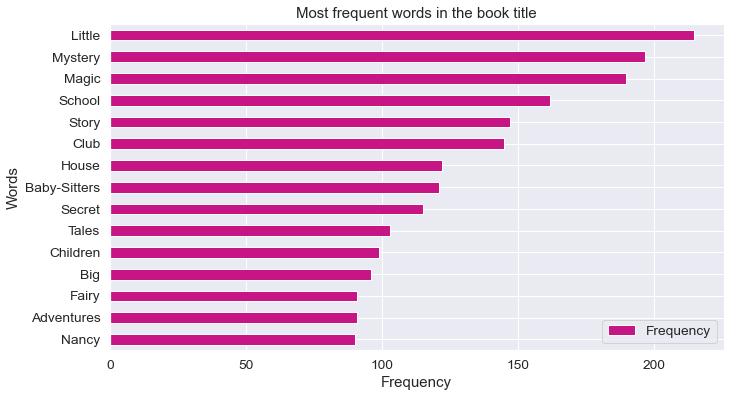

In [21]:
#word frequency for title
books['title_words'] = books.title.apply(lambda x: re.sub(r'\d+','', x)).apply(lambda x: word_tokenize(x)).apply(lambda lst: [w for w in lst if w[0] not in string.punctuation]) 
stopwords = set(nltk.corpus.stopwords.words('english'))
include_stopwords = {'s','book'}
stopwords |= include_stopwords
def remove_stopwords(tokens):
    return [t for t in tokens if t.lower() not in stopwords]
books['title_words'] = books['title_words'].map(remove_stopwords)
counter = Counter()
books['title_words'].map(counter.update)
freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['Frequency'])
freq_df.index.name = 'Words'
freq_df = freq_df.sort_values(by = 'Frequency', ascending = False)
#Plot
ax = freq_df.head(15).plot(kind='barh', figsize = (11,6), color = 'mediumvioletred')
ax.invert_yaxis()
ax.set(xlabel='Frequency', title='Most frequent words in the book title')

Some of the most frequent words in the title (after removing stop words) are Little, Mystery, Magic, School and Story. 

The top two and three sequence words, bigram and trigram respectively are evaluated using tf-idf vectorizer. Tf-idf vectorizer gives greater weight to word-sets that occurs more frequently in the description of that specific book and is present in fewer book descriptions.

<AxesSubplot:title={'center':'Bigram disribution for the top 20 words in the book description'}, xlabel='Bigram'>

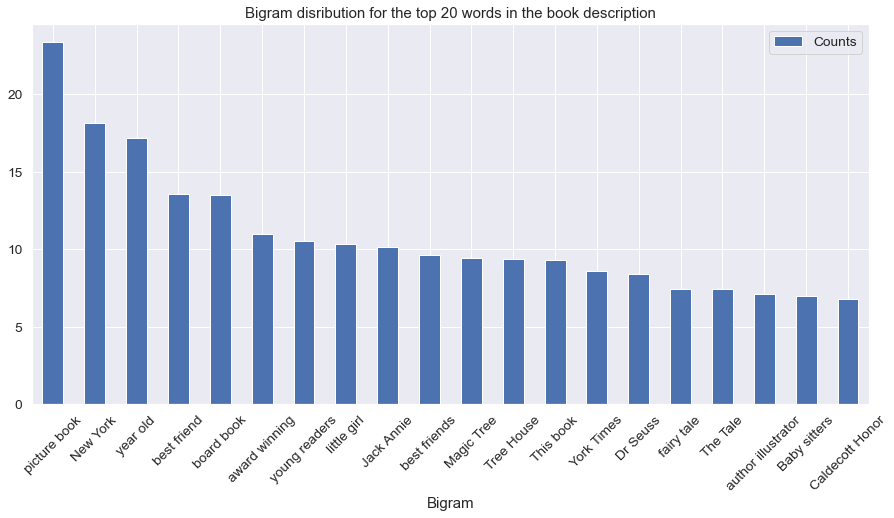

In [22]:
#Converting text descriptions into vectors using TF-IDF using Bigram
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(books['description'])
total_words = tfidf_matrix.sum(axis=0) 
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)
#converting into dataframe 
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'Bigram', 1: 'Counts'}, inplace = True) 
#Taking first 20 records
bigram = bigram.head(20)
#Plotting the bigram distribution
bigram.plot(x ='Bigram', y='Counts', kind = 'bar', title = "Bigram disribution for the top 20 words in the book description", figsize = (15,7), rot = 45)


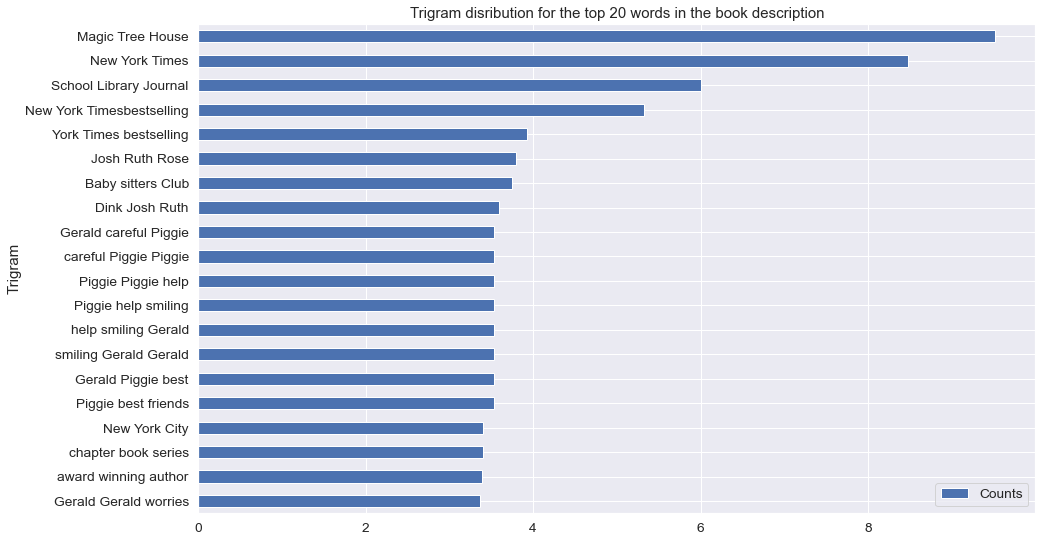

In [23]:
#Converting text descriptions into vectors using TF-IDF using Bigram
tf = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(books['description'])
total_words = tfidf_matrix.sum(axis=0) 
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)
#converting into dataframe 
trigram = pd.DataFrame(freq)
trigram.rename(columns = {0:'Trigram', 1: 'Counts'}, inplace = True) 
#Taking first 20 records
trigram = trigram.head(20)
#Plotting the bigram distribution
ax = trigram.plot(x ='Trigram', y='Counts', kind = 'barh',title = "Trigram disribution for the top 20 words in the book description", figsize = (15,9))
ax.invert_yaxis()

Some of the top 3-sequence words in the descriptions are Magic Tree House, New York Times, School Library Journal. 

In [24]:
book_ids = list(books.book_id.unique())
len(book_ids), len(books.title.unique())

(5985, 5985)

The individual user item data is loaded. Book ids with meta data are only considered.

In [25]:
interactions_chunk = pd.read_json(os.path.join('data','goodreads_interactions_children.json.gz'), lines = True, chunksize = 1000)
df_interactions = pd.concat(chunk[(chunk.book_id.isin(book_ids))] for chunk in interactions_chunk)

In [26]:
df_interactions.head()

,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
0,8842281e1d1347389f2ab93d60773d4d,10893214,5d0e4e8825c68740703f65a18813fc93,False,0,,Fri Feb 24 09:00:30 -0800 2017,Fri Feb 24 09:00:30 -0800 2017,,
1,8842281e1d1347389f2ab93d60773d4d,33282947,f171a68daa8092d8aea3dccc2e025a81,False,0,,Fri Feb 10 10:47:53 -0800 2017,Fri Feb 10 10:48:21 -0800 2017,,
2,8842281e1d1347389f2ab93d60773d4d,11387515,2fd3cd1acb30b099c135e358669639da,False,0,,Thu Jan 26 13:35:10 -0800 2017,Thu Jan 26 13:35:10 -0800 2017,,
5,8842281e1d1347389f2ab93d60773d4d,23310161,f4b4b050f4be00e9283c92a814af2670,True,4,Fun sequel to the original.,Tue Nov 17 11:37:35 -0800 2015,Tue Nov 17 11:38:05 -0800 2015,,
7,8842281e1d1347389f2ab93d60773d4d,817720,75fd46041466ceb406b7fd69b089b9c5,True,5,,Wed May 20 21:29:23 -0700 2015,Wed May 20 21:29:23 -0700 2015,,


In [27]:
df_rated = df_interactions[df_interactions.rating != 0]
df = df_rated.drop(columns = ['date_added','read_at','started_at','review_text_incomplete', 'is_read'])
df.reset_index(drop = True, inplace = True)

In [28]:
df.head()

,user_id,book_id,review_id,rating,date_updated
0,8842281e1d1347389f2ab93d60773d4d,23310161,f4b4b050f4be00e9283c92a814af2670,4,Tue Nov 17 11:38:05 -0800 2015
1,8842281e1d1347389f2ab93d60773d4d,817720,75fd46041466ceb406b7fd69b089b9c5,5,Wed May 20 21:29:23 -0700 2015
2,8842281e1d1347389f2ab93d60773d4d,1969280,5809d5592ee32745e048a9c67ac27100,5,Wed Dec 17 00:37:25 -0800 2014
3,8842281e1d1347389f2ab93d60773d4d,17290220,22d424a2b0057b18fb6ecf017af7be92,5,Wed Jan 25 13:56:12 -0800 2017
4,8842281e1d1347389f2ab93d60773d4d,231850,7e91788ed33bd25ccc9d293160b80fcd,5,Wed Mar 22 11:47:29 -0700 2017


In [30]:
book_nratings = pd.DataFrame(df.groupby('book_id')['user_id'].nunique()).reset_index()
book_nratings.columns = ['book_id', 'n_users_rated']

Books with atleast 50 ratings and users who have rated atleast 50 books are only considered.

In [31]:
df_books = df.merge(book_nratings[book_nratings.n_users_rated >= 100], on = 'book_id')
df_books.shape

(3671606, 6)

In [32]:
user_nratings = pd.DataFrame(df_books.groupby('user_id')['book_id'].nunique()).reset_index()
user_nratings.columns = ['user_id', 'n_books_rated']

In [33]:
dfbu = df_books.merge(user_nratings[user_nratings.n_books_rated >= 50], on = 'user_id')
dfbu.head()

,user_id,book_id,review_id,rating,date_updated,n_users_rated,n_books_rated
0,d1e368a7d2870eb6fbf6e0d350568a2d,23310161,87fb7685b0b1aa774cc14c330bdcfadf,4,Mon Aug 31 07:07:40 -0700 2015,1481,316
1,d1e368a7d2870eb6fbf6e0d350568a2d,1969280,3f21c462c88b57186b6f0c2becc121e2,3,Wed Sep 28 17:03:19 -0700 2016,462,316
2,d1e368a7d2870eb6fbf6e0d350568a2d,17290220,0a07041c829634236433f24409860be8,4,Wed Sep 28 16:45:23 -0700 2016,842,316
3,d1e368a7d2870eb6fbf6e0d350568a2d,231850,f1ed8ca9c5abfe0286f00b97d4d3965a,4,Tue Jan 05 19:13:00 -0800 2010,10215,316
4,d1e368a7d2870eb6fbf6e0d350568a2d,4948,285df57ea41be7f41d5a404d2ffad03a,5,Fri Jul 25 11:00:09 -0700 2014,18497,316


In [42]:
dfbu.sort_values(by = ['n_books_rated','n_users_rated']).head()

,user_id,book_id,review_id,rating,date_updated,n_users_rated,n_books_rated
568979,74899fef1c1496388e46303025f8b36a,370565,b4c7d7524422fcd160a6f2a533c87ac5,4,Tue Sep 27 17:07:42 -0700 2011,100,50
822009,3dd4a76cd8c9a185001fe7b8cf71f982,22323689,81739b697b5fc0d478295e61c2c95685,5,Sun Oct 25 17:51:01 -0700 2015,100,50
839229,0bea9897b8a5de61d6d94ba49bb862f3,13553362,2900f1a857019eb47d7c9f17ed74a85e,5,Sat Dec 05 09:54:08 -0800 2015,100,50
1012066,cb20762934819a13eb3ccb4217b0ab91,22323689,e53d9eca940d84da11c906c776e8eb31,3,Tue Dec 27 20:09:15 -0800 2016,100,50
1064131,fd802bf583d709efd9d64af0e9fa3e46,311212,eae71f7354ce2981e6a4fb565ac69cca,5,Mon Dec 12 14:26:17 -0800 2016,100,50


In [35]:
dfbu_sparse = dfbu.pivot(index = 'user_id', columns = 'book_id', values = 'rating')

In [36]:
dfbu_sparse.shape

(12174, 3367)

In [37]:
dfbu_sparse.head()

book_id,5,50,61,93,378,903,1167,1852,2839,2998,3008,3562,3636,3638,3685,3743,3782,3784,3797,3799,3980,4117,4600,4947,4948,...,31145180,31146957,31159611,31215005,31315554,31423547,31423563,31491773,31522122,31625795,31743096,31934478,31934710,32198259,32498545,32819894,32940857,33016249,33158525,33282947,33376257,33606658,33828095,34504361,34608694
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000192962b87d560f00b06fdcbd71681,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
00034e7004b7de8f5da32c23b1330859,3.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000387b0e3d77b6dcc36a66d5cc27347,4.0,1.0,NaN,NaN,2.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0006a5b8cda1ba6d7b911dc575f6547b,5.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0019e891665331a2d57eceda5f73cc43,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
dfbu_sparse = dfbu_sparse.fillna(0)
dfbu_sparse.head()

book_id,5,50,61,93,378,903,1167,1852,2839,2998,3008,3562,3636,3638,3685,3743,3782,3784,3797,3799,3980,4117,4600,4947,4948,...,31145180,31146957,31159611,31215005,31315554,31423547,31423563,31491773,31522122,31625795,31743096,31934478,31934710,32198259,32498545,32819894,32940857,33016249,33158525,33282947,33376257,33606658,33828095,34504361,34608694
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000192962b87d560f00b06fdcbd71681,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
00034e7004b7de8f5da32c23b1330859,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000387b0e3d77b6dcc36a66d5cc27347,4.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0006a5b8cda1ba6d7b911dc575f6547b,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0019e891665331a2d57eceda5f73cc43,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
bu_sparse_array = dfbu_sparse.to_numpy()

In [40]:
sparsity = 1 - (np.count_nonzero(bu_sparse_array)/bu_sparse_array.size)
print(f"The sparsity of the user item data is {round(sparsity,3)}")

The sparsity of the user item data is 0.97


In [43]:
dfbu_sparse.to_csv("data//cleaned_sparse_user_ratings_info.csv")
books.to_csv("data//cleaned_books_info.csv")
dfbu.to_csv("data//cleaned_user_ratings_info")